#Analyse de sentiments de tweeter
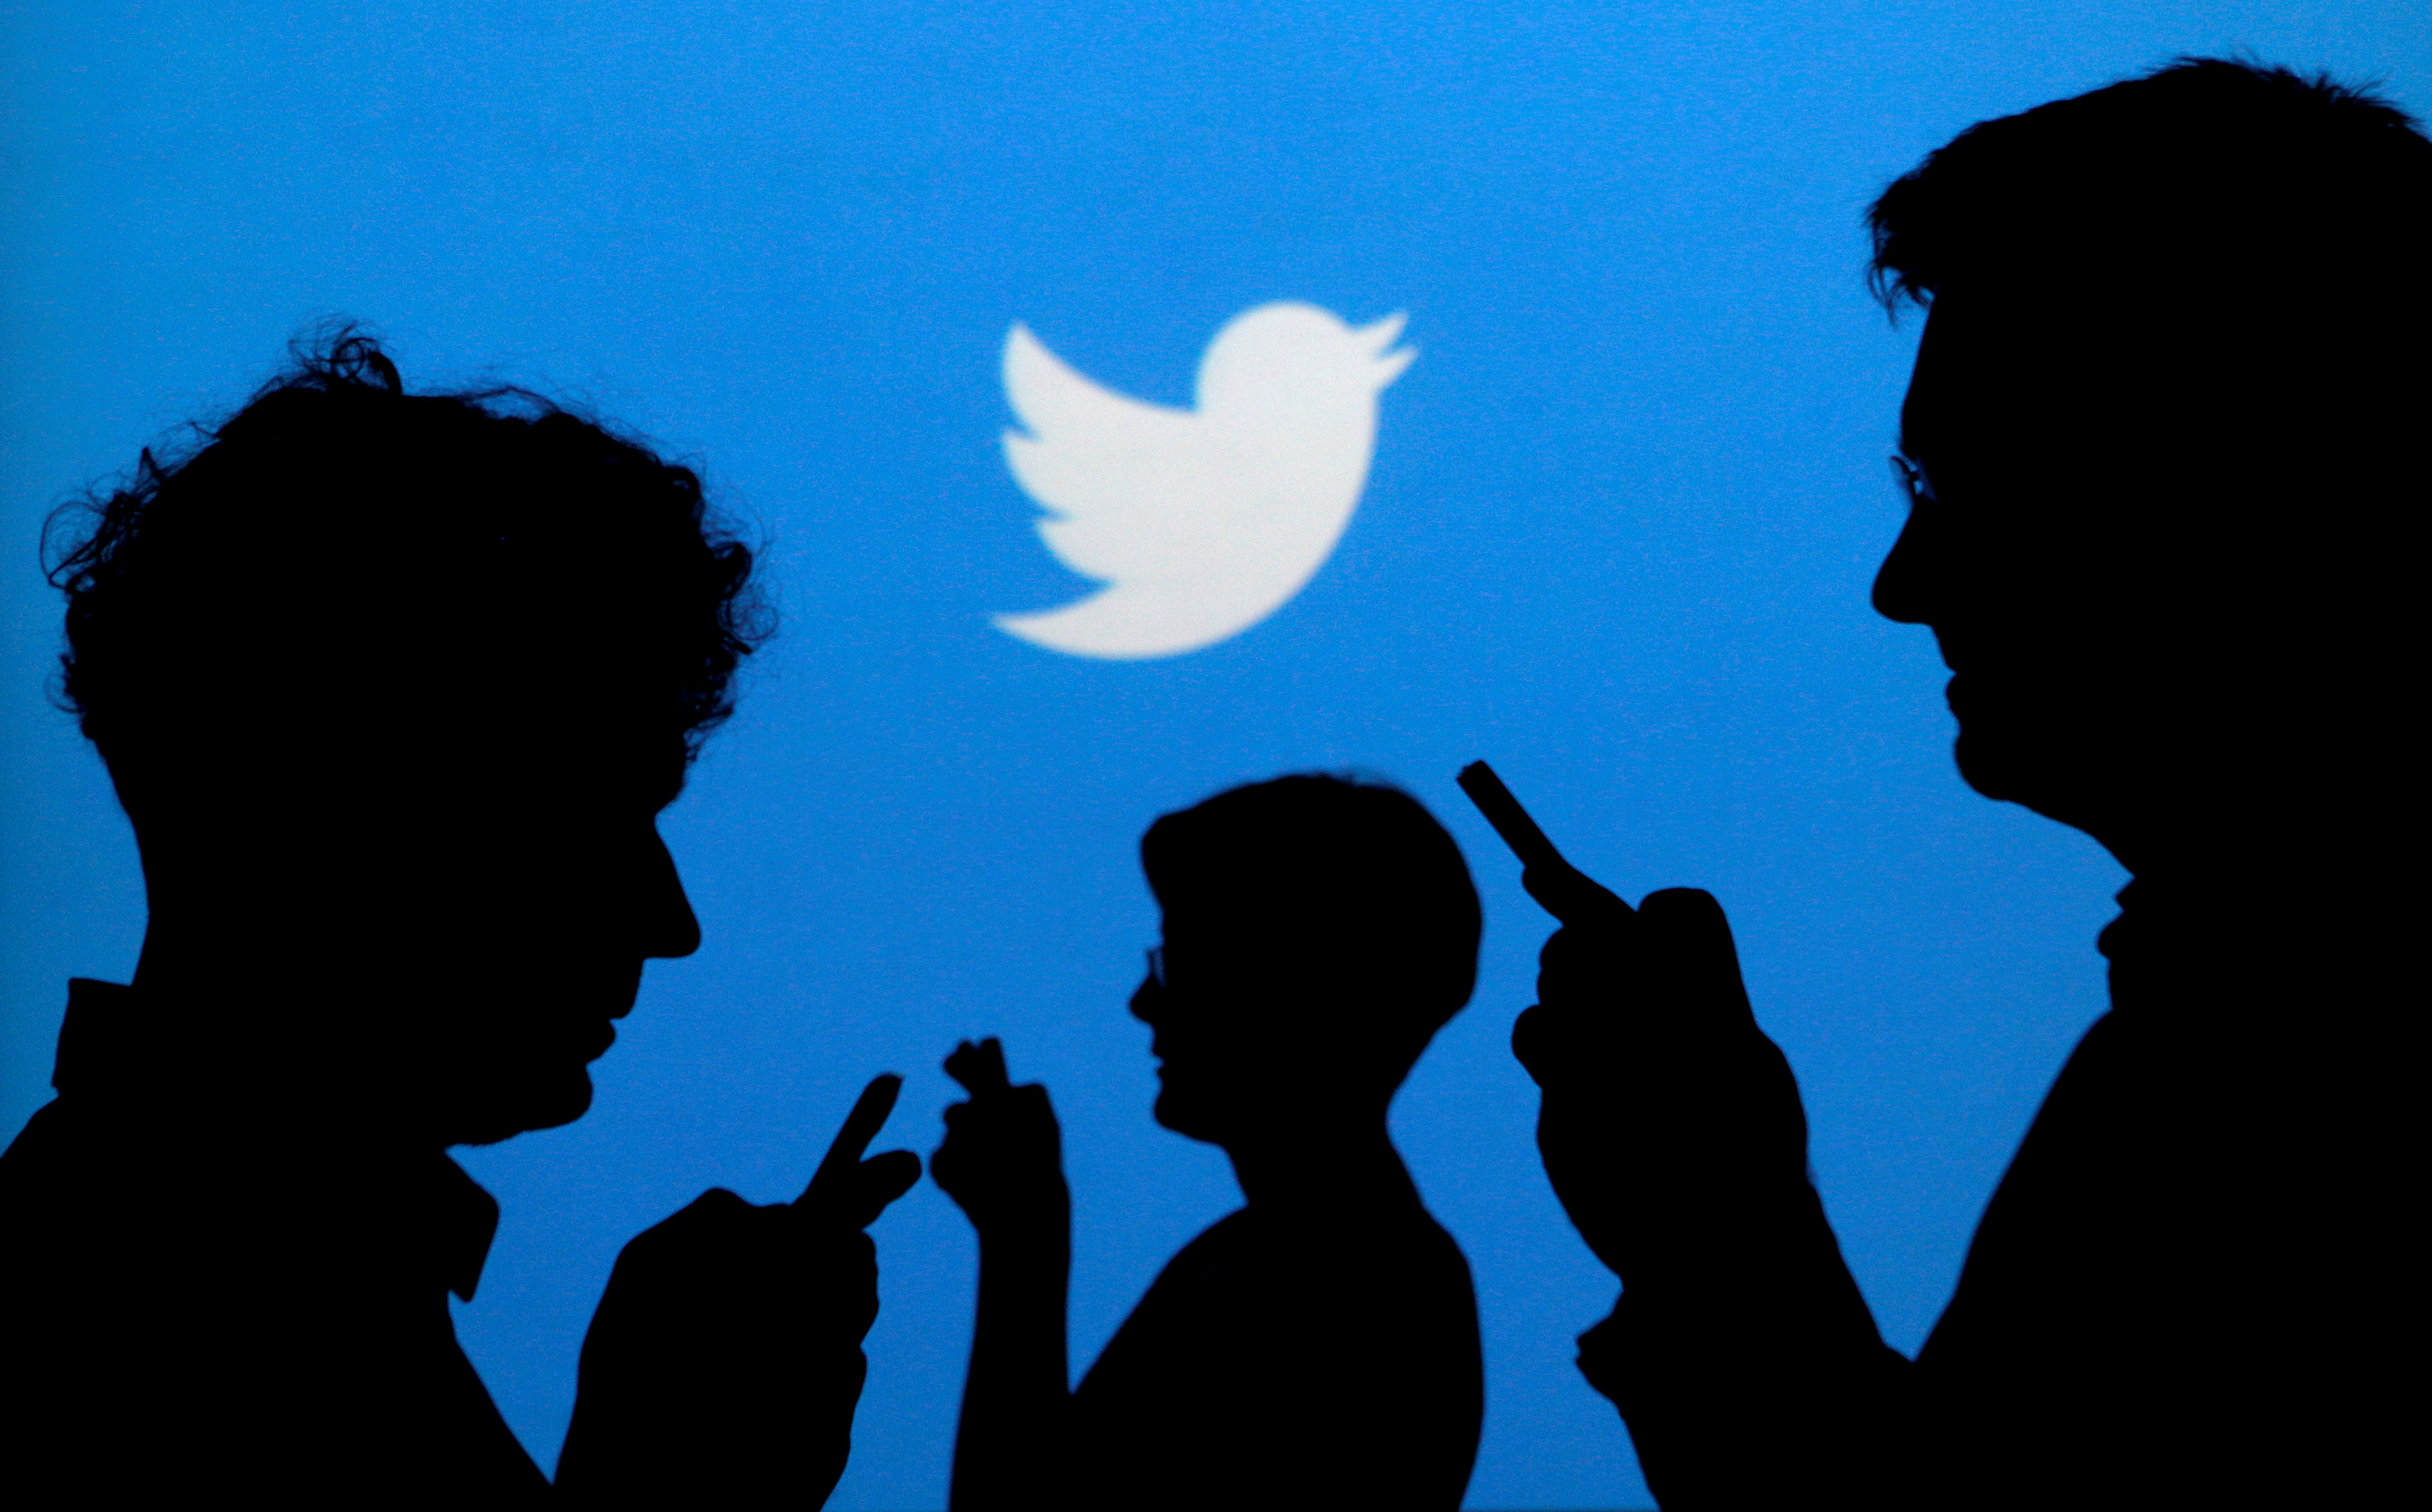

## 0.Importation des bibliothèques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.metrics import confusion_matrix,classification_report
import re

## 1.Lecture et exploration des données

In [2]:
df = pd.read_csv('/content/sample_data/Internet Movie Database_Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [5]:
df.shape

(50000, 2)

In [6]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.duplicated().sum()

418

In [8]:
df.drop_duplicates(keep = 'first', inplace=True)

In [9]:
df.head

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[49582 rows x 2 columns]>

In [10]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [11]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocessing_text(text):
    # Remove html tag
    sentence = remove_tags(text)
    # Remove link
    sentence = re.sub(r'https:\/\/[a-zA-Z]*\.com',' ',sentence)
    # Remove number
    sentence = re.sub(r'\d+',' ',sentence)
    # Remove white space
    sentence = re.sub(r'\s+',' ',sentence)
    # Remove single character
    sentence = re.sub(r"\b[a-zA-Z]\b", ' ', sentence)
    # Remove bracket
    sentence = re.sub(r'\W+',' ',sentence)
    # Make sentence lowercase
    sentence = sentence.lower()
    return sentence

In [12]:
pre_proces = []
sentences = list(df['review'])
for sen in sentences:
    pre_proces.append(preprocessing_text(sen))
pre_proces[0]

'one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare forget pretty picture

In [13]:
df["sentiment"].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

Encoder la variable cible comme un type énuméré ou une variable catégorielle

In [14]:
sentiment_label = df.sentiment.factorize()
sentiment_label 

(array([0, 0, 0, ..., 1, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

Prendre les valeurs de la colonne "text"

In [15]:
tweet = pre_proces


## 3.Traitement du texte

Tokenize : Cette classe permet de vectoriser un corpus de texte, en transformant chaque texte en une séquence d'entiers (chaque entier étant l'indice d'un token dans un dictionnaire)

In [16]:
tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1 
encoded_docs = tokenizer.texts_to_sequences(tweet) # chaque tweet encodé
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [17]:
print(tweet[0])
print(encoded_docs[0])

one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare forget pretty pictures

In [18]:
print(padded_sequence[0])

[ 367   36  554   87    5 3760    7    1  349  351    3    1  639    6
    5  426 3042   11    9    5    1  350    4    1 2504 1026    6 2669
 1387   18  510   30 4577 2433    3    1 1164  111   26    1   23 2861
    2  380   32    5   19  291   18    1 4822 2873  510    5  334    4
  103 4942 2397    2   48   32  318    2   21  107  217  234   56  128
    1  276 1305    3    1  114    5  672    4    1  187    9    6  260
  111   73  269  563 2979  809  178 1275 4080   13 2439 1199  809 1403
  809  855 3042  147  929  179    1   84  390  119  203 3187   64   11
   32 1583    6   10 2204  405  128   10 1555   13    6   15   11  284
   48 1379 1245   13 3042    2  185    4    1  291 2002    3 2089  554
   19   37  554   15 4902   31  224   25 2942   39   13   31  224  486
   18  618    2   71  234   14    6   65  632  686  105  642   79 1164
  672    4   62  556    3  882 1975   36 1164  542  144 3042   17  192
  417 3753   14   43    5 3313  785 1560   41   17   46   71    7 1175
   14 

In [19]:
print(padded_sequence)

[[ 367   36  554 ...  122 4023  472]
 [   0    0    0 ... 1942   65  214]
 [   0    0    0 ...   61   14  342]
 ...
 [   0    0  226 ...    2 3896    2]
 [   0    0    0 ...   46  719   40]
 [   0    0    0 ...  782    8   12]]


model.add(tf.keras.layers.Embedding(vocab_size, embedding_vector_length , input_length=200))

Le modèle prendra en entrée une matrice d'entiers de taille (batch, input_length)

le plus grand entier (i.e. l'index du mot) dans l'entrée ne devrait pas être plus grand que la taille du vocabulaire. 

## 4.Construction et entraînement du modèle

In [22]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           3258848   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 3,275,499
Trainable params: 3,275,499
Non-trainable params: 0
______________________________________________

In [25]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
1240/1240 [==============================] - 374s 299ms/step - loss: 0.4330 - accuracy: 0.7951 - val_loss: 0.3429 - val_accuracy: 0.8699
Epoch 2/10
1240/1240 [==============================] - 370s 298ms/step - loss: 0.3027 - accuracy: 0.8788 - val_loss: 0.2870 - val_accuracy: 0.8792
Epoch 3/10
1240/1240 [==============================] - 369s 297ms/step - loss: 0.2801 - accuracy: 0.8873 - val_loss: 0.2933 - val_accuracy: 0.8764
Epoch 4/10
1240/1240 [==============================] - 372s 300ms/step - loss: 0.2587 - accuracy: 0.8966 - val_loss: 0.2942 - val_accuracy: 0.8811
Epoch 5/10
1240/1240 [==============================] - 371s 299ms/step - loss: 0.2483 - accuracy: 0.9018 - val_loss: 0.3059 - val_accuracy: 0.8804
Epoch 6/10
1240/1240 [==============================] - 373s 300ms/step - loss: 0.2424 - accuracy: 0.9043 - val_loss: 0.3254 - val_accuracy: 0.8802
Epoch 7/10
1240/1240 [==============================] - 372s 300ms/step - loss: 0.2315 - accuracy: 0.9092 - val_

## 5.Graphes accuracy et pertes pour les données d'entrainement et de validation (test)

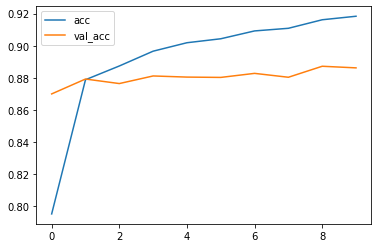

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

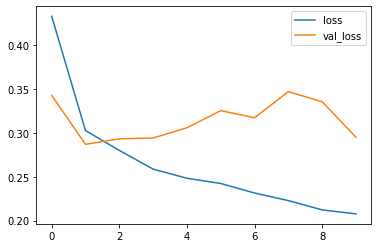

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

## 6.Prédictions

Des prédictions sur nos propres mots 

In [28]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [29]:
test_sentence1 = "one of the other reviewers has mentioned that after watching just oz episode you ll be hooked."
predict_sentiment(test_sentence1)

Predicted label:  positive


In [30]:
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  negative


## 7.Tout Refaire avec le texte traduit

Ici nous n'avons traduit que les 1000 premiers tweets car la traduction prend beaucoup de temps

In [32]:
!pip install googletrans==3.1.0a0
from googletrans import Translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.4 MB/s 
     |████████████████████████████████| 1.4 MB 3.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=d91448e43c1565bb45647850d3e3c210eff0474d35f16258a9a89ccd23eee307
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [33]:
translator = Translator()

In [35]:
df['texte_traduit'] = df['review'].head(1000).apply(lambda x: translator.translate(x, src='en', dest='fr').text)
df['texte_traduit'] = df['texte_traduit'].head(1000)

In [36]:
df.shape

(49582, 3)

In [39]:
df = df[['sentiment','texte_traduit']].head(1000)
df

,sentiment,texte_traduit
0,positive,L'un des autres commentateurs a mentionné qu'a...
1,positive,Une merveilleuse petite production. <br /><br ...
2,positive,Je pensais que c'était une merveilleuse façon ...
3,negative,"En gros, il y a une famille où un petit garçon..."
4,positive,"""L'amour au temps de l'argent"" de Petter Matte..."
...,...,...
995,positive,Rien n'est sacré. Demandez à Ernie Fosselius. ...
996,negative,J'ai détesté. Je déteste l'inanité prétentieus...
997,negative,J'essaie généralement d'être professionnel et ...
998,negative,"Si, comme moi, vous allez voir ça dans un cour..."


In [40]:
pre_proces_trad = []
sentences_trad = list(df['texte_traduit'])
for sen in sentences_trad:
    pre_proces_trad.append(preprocessing_text(sen))
pre_proces_trad[0]

' un des autres commentateurs mentionné qu après avoir regardé un épisode de seulement oz vous serez accro ils ont raison car est exactement ce qui est passé avec moi la première chose qui frappé chez oz est sa brutalité et ses scènes de violence sans faille qui se sont installées dès le mot go croyez moi ce est pas un spectacle pour les timides ou les timides cette émission ne fait pas de mal en matière de drogue de sexe ou de violence est hardcore dans usage classique du mot il appelle oz car est le surnom donné au pénitencier état à sécurité maximale oswald il se concentre principalement sur emerald city une section expérimentale de la prison où toutes les cellules ont des façades en verre et font face à intérieur donc intimité est pas une priorité em city abrite de nombreux aryens musulmans gangstas latinos chrétiens italiens irlandais et bien autres donc les échauffourées les regards de la mort les affaires louches et les accords louches ne sont jamais loin je dirais que le princi

In [41]:
tweet_trad = pre_proces_trad

In [42]:
df.shape

(1000, 2)

In [43]:
sentiment_label = df.sentiment.factorize()

In [44]:
tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(tweet_trad)
vocab_size = len(tokenizer.word_index) + 1 
encoded_docs = tokenizer.texts_to_sequences(tweet_trad) # chaque tweet encodé
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [45]:


embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 


history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=10, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           646912    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 663,563
Trainable params: 663,563
Non-trainable params: 0
________________________________________________

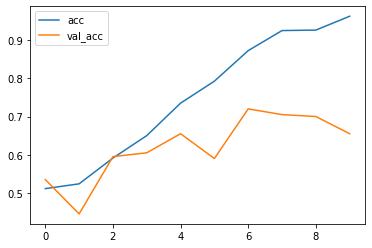

<Figure size 432x288 with 0 Axes>

In [46]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

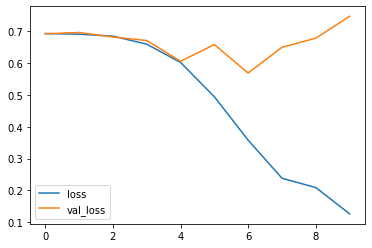

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [48]:
test_sentence1 = "c'était une merveilleuse façon"
predict_sentiment(test_sentence1)

Predicted label:  positive


In [50]:
test_sentence2 = "C'est pas bien du tout "
predict_sentiment(test_sentence2)

Predicted label:  positive
